# Auswertung - Verteilung der Daten

In diesem ersten Abschnitt soll die Verteilung, der bei der Evaluierung vom 12.6 - 14.6 erhobenen Daten, festgestellt werden. Dabei ist einersteits interessant wie viele Datenpunkte pro Person, Area of Interest (AOI) bzw. pro Position erhoben wurden. Dieses erste Teil der Auswertung soll daher einen ersten Überblick über die erobenen Daten gewähren und zusätzlich Indiezien darüber liefern, welche erste Limitationen für das, der Evaluation zu grundelegende, System erkannt werden können.

Zusammenfassung: https://docs.google.com/document/d/1ed914XcL-6hsM_Uw_CaPCbtNpD9379khB75hmfXUMmc/edit?usp=sharing

### Auswertungs-Fragen:
* [Frage 1: Gesamtzahl der gesammelten Daten](#cell1)
* [Frage 2: Verhältnis von “Erkannt” und “Nicht-Erkannt”](#cell2)
* [Frage 3: Verteilung der Hits auf die einzelnen AOIs](#cell3)
* [Frage 4: Verteilung der Hits auf die einzelnen Positionen](#cell4)
* [Frage 5: Verteilung der Hits auf die AOIs pro Position](#cell5)
* [Frage 6: Verteilung der Hits auf die Clients](#cell6)

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from IPython.display import display, HTML
import numpy as np
from scipy import stats
import math

from datetime import datetime

In [4]:
root = '../0_annotation'
file_names = []

for subdir, dirs, files in os.walk(root):
    for file in files:
        if 'annotation' not in file or '.csv' not in file:
            continue
        file_names.append(os.path.join(subdir, file).replace('\\', '/'))

# Nutzerdaten

<a id="cell1"></a>
# Frage 1: Gesamtzahl der gesammelten Daten

**Ziel:** Ersten Überblick über die Daten. Was ist die absoulte Zahl an erkannten Blicken pro Nutzer. Welche Nutzer haben besonders viele Blicke, welche extrem wenig.

In [5]:
info_titles = [
    'Frames',
    'Zeitpunkt',
    'Test Person',
    'Frames mit Gesicht',
    'Frames mit Blick',
    'Alter',
    'Groesse',
    'Brille',
    'Geschlecht',
    'Bart'
]

# Important vars for further analysis

info_data = []
counter_gaze = []
frames_with_face = []
testers = []
aoi_hits = []
position_hits = {}
positions_by_aoi_hits = []
client_data = {}

giant_data_frame = pd.DataFrame()

user = pd.read_csv('../participants.csv', sep=',', engine='python', encoding='utf-8')

for f in file_names:
    df = pd.read_csv(f, sep=',', engine='python')
    
    giant_data_frame = giant_data_frame.append(df)
    
    # meta data
    count_total = len(df['frame'])
    last_ts = datetime.fromtimestamp(df['server_timestamp'][count_total - 1])
    test_person = str((df['annotation_test_person_id'][count_total - 1]))[:-1]
       
    
    # gaze & face hits
    count_face = len(df[(df[['eye_lmk_X_0','eye_lmk_Y_0','eye_lmk_Z_0']] != 0).all(axis=1)]['frame'])
    count_gaze = len(df[(df[['gaze_direction_0_x','gaze_direction_0_y','gaze_direction_0_z']] != 0).all(axis=1)]['frame'])
    
    # aoi & positions hits
    uniqueValues, occurCount = np.unique(df[(df[['gaze_direction_0_x','gaze_direction_0_y','gaze_direction_0_z']] != 0).all(axis=1)]['annotation_aoi'],
                                         return_counts=True)
                 
    current_aois = pd.DataFrame(occurCount, index =uniqueValues, columns=["tester_" + test_person]) 
    
    uniqueValues, occurCount = np.unique(df[(df[['gaze_direction_0_x','gaze_direction_0_y','gaze_direction_0_z']] != 0).all(axis=1)]['annotation_pos'],
                                         return_counts=True)
    current_positions = occurCount
    
    # aoi vs. positions hits
    tempFrame = df[(df[['gaze_direction_0_x','gaze_direction_0_y','gaze_direction_0_z']] != 0).all(axis=1)]
    result_pos_aoi = tempFrame.groupby(['annotation_pos','annotation_aoi']).size().reset_index().rename(columns={0:"tester_" + test_person})
        
    #client
    uniqueValues, occurCount = np.unique(df[(df[['gaze_direction_0_x','gaze_direction_0_y','gaze_direction_0_z']] != 0).all(axis=1)]['client_id'],
                                         return_counts=True)
    client_hits = occurCount
    
    # extract data separately
    age = user[['Age']].loc[int(test_person)-1].values[0] 
    size = user[['Size (cm)']].loc[int(test_person)-1].values[0] 
    glasses = user[['Glasses']].loc[int(test_person)-1].values[0] 
    gender = user[['Gender']].loc[int(test_person)-1].values[0] 
    beard = user[['Beard']].loc[int(test_person)-1].values[0] 
    info_data.append([count_total, last_ts, test_person, count_face, count_gaze, age, size, glasses, gender, beard])
    counter_gaze.append(count_gaze)
    frames_with_face.append(count_face)    
    positions_by_aoi_hits.append(result_pos_aoi)
    
    aoi_hits.append(current_aois)
    position_hits['tester_' + test_person] = current_positions
    client_data['tester_' + test_person] = client_hits
    
    testers.append(test_person)

aoi_hits = pd.concat(aoi_hits, axis=1)
user_data = pd.DataFrame(info_data, columns=info_titles).sort_values(by=['Frames mit Blick'], ascending=False)

user_data


,Frames,Zeitpunkt,Test Person,Frames mit Gesicht,Frames mit Blick,Alter,Groesse,Brille,Geschlecht,Bart
17,13033,2019-06-12 15:57:50,14,13033,981,27,185,True,MALE,False
4,17325,2019-06-12 14:52:33,12,17325,891,37,164,True,MALE,False
19,14934,2019-06-13 13:09:13,32,14934,773,20,186,False,MALE,False
9,16173,2019-06-13 14:34:27,36,16173,753,29,168,False,FEMALE,False
41,9089,2019-06-14 17:48:49,48,9089,744,32,179,False,MALE,True
10,14585,2019-06-12 11:20:43,06,14585,694,23,174,False,FEMALE,False
21,12552,2019-06-12 11:02:52,05,12552,667,20,180,False,MALE,False
37,18360,2019-06-13 09:39:52,24,18360,650,29,169,False,FEMALE,False
36,12836,2019-06-13 14:06:45,34,12836,504,25,192,False,MALE,False
28,15467,2019-06-14 09:24:36,38,15467,479,24,182,False,MALE,False


In [6]:
glasses_true_avg = user_data.loc[(user_data['Brille']== True)][['Frames mit Blick']].mean(axis=0).values[0]
glasses_false_avg = user_data.loc[(user_data['Brille']== False)][['Frames mit Blick']].mean(axis=0).values[0]

male_avg = user_data.loc[(user_data['Geschlecht']== 'MALE')][['Frames mit Blick']].mean(axis=0).values[0]
female_avg = user_data.loc[(user_data['Geschlecht']== 'FEMALE')][['Frames mit Blick']].mean(axis=0).values[0]

beard_true_avg = user_data.loc[(user_data['Bart']== True)][['Frames mit Blick']].mean(axis=0).values[0]
beard_false_avg = user_data.loc[(user_data['Bart']== False)][['Frames mit Blick']].mean(axis=0).values[0]

print("Brille: " + str(glasses_true_avg))
print("Keine Brille: " + str(glasses_false_avg))
print("Mann: " + str(male_avg))
print("Frau: " + str(female_avg))
print("Bart: " + str(beard_true_avg))
print("Kein Bart: " + str(beard_false_avg))

Brille: 277.1
Keine Brille: 380.6666666666667
Mann: 364.7931034482759
Frau: 303.95238095238096
Bart: 257.85714285714283
Kein Bart: 352.48837209302326


In [1]:
size_hits = user_data[['Frames mit Blick', 'Groesse']].sort_values(by=['Groesse'])

test = user_data[['Frames mit Blick', 'Groesse']]
bins = pd.cut(test['Groesse'], [155, 160, 165, 170, 175, 180, 185, 190, 195])
test = test.groupby(bins)['Frames mit Blick'].agg(['count', 'sum'])
test['Result'] = test['sum']/test['count']

print(test)

plot = test[['Result']].plot(kind='line')
plot.set_ylabel("Durschnittliche Anzahl erkannte Blicke")

print((test[['Result']]/test[['Result']].sum() * 100)[['Result']])

NameError: name 'user_data' is not defined

In [1]:
ax_1 = user_data[['Frames mit Blick', 'Test Person']].sort_values(by=['Frames mit Blick'], ascending=False).plot(kind='bar')
ax_1.set_xticklabels(user_data[['Test Person']].values.transpose()[0])
ax_1.set_xlabel("Testperson (geordnet nach Anzahl erkannter Blicke)")
ax_1.set_ylabel("Anzahl erkannte Blicke")

ax_2 = user_data[['Frames mit Blick', 'Test Person']].sort_values(by=['Test Person'], ascending=False).plot(kind='bar')
ax_2.set_xticklabels(user_data[['Test Person']].values.transpose()[0])
ax_2.set_xlabel("Testperson (geordnet nach Testernummer)")
ax_2.set_ylabel("Anzahl erkannte Blicke")

top_ten = user_data[['Frames mit Blick', 'Test Person', 'Brille', 'Groesse', 'Bart']].sort_values(by=['Frames mit Blick'], ascending=False).head(10)

total_count = user_data[['Frames mit Blick']].sort_values(by=['Frames mit Blick'], ascending=False).sum()
top_ten_count = user_data[['Frames mit Blick']].sort_values(by=['Frames mit Blick'], ascending=False).head(10).sum()

percent_face = str(round(top_ten_count / (total_count/100), 2))

user_size = user_data[['Groesse', 'Frames mit Blick']].sort_values(by=['Frames mit Blick'], ascending=False).head(10).sum()
print(user_size)


NameError: name 'user_data' is not defined

          count   sum      Result    Percent
Alter                                       
(20, 21]      1   218  218.000000   5.018368
(21, 22]      6  1502  250.333333   5.762683
(22, 23]      3   976  325.333333   7.489185
(23, 24]      8  2273  284.125000   6.540568
(24, 25]      4  1009  252.250000   5.806804
(25, 26]      2   543  271.500000   6.249940
(26, 27]      4  1814  453.500000  10.439587
(27, 28]      3   712  237.333333   5.463422
(28, 29]      3  1643  547.666667  12.607307
(29, 30]      1   304  304.000000   6.998091
(30, 31]      2   374  187.000000   4.304747
(31, 34]      3  1177  392.333333   9.031528
(34, 37]      3  1550  516.666667  11.893686
(37, 38]      1   104  104.000000   2.394084


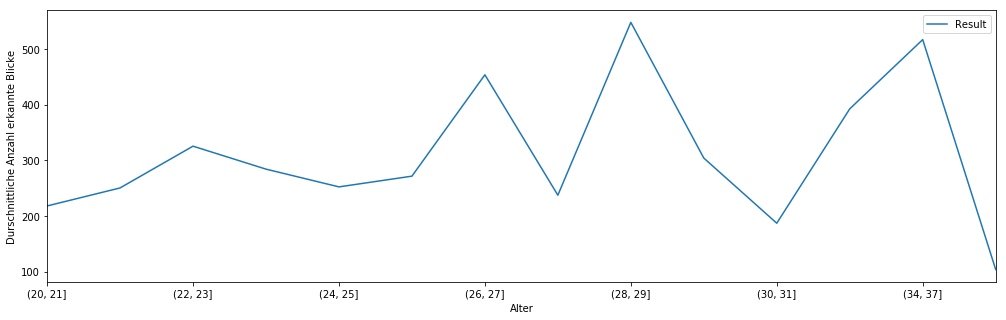

In [183]:
age_hits = user_data[['Frames mit Blick', 'Alter']].sort_values(by=['Alter'])

test = user_data[['Frames mit Blick', 'Alter']]
bins = pd.cut(test['Alter'], [20, 21,22,23,24,25,26,27,28,29,30,31,34,37,38])
test = test.groupby(bins)['Frames mit Blick'].agg(['count', 'sum'])
test['Result'] = test['sum']/test['count']

plot = test[['Result']].plot(kind='line')
plot.set_ylabel("Durschnittliche Anzahl erkannte Blicke")

test['Percent'] = (test[['Result']]/test[['Result']].sum() * 100)[['Result']]
print(test)

**Ergebnis:** Besonders viele werden bei 12, 36, 06, 14, 32, 05, 34, 24, 48 erkannt. Fast keine bei 28, 41, 19, 11, 39, 02, 39.

<a id="cell2"></a>

# Frage 2: Verhältnis von “Erkannt” und “Nicht-Erkannt”

**Ziel:** Wie groß ist der Teil der irrelevanten Informationen (Nicht-Erkannt), im Verhältnis zu relevanten Informationen (Erkannt).

Frames mit Gesicht: 743519
Frames mit Blick: 16962
Verhältnis zwischen Gesicht (97.77%) und Blick(2.23%)


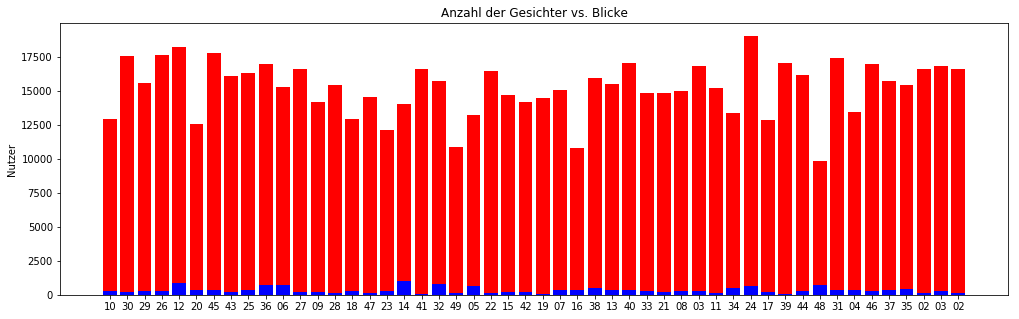

In [8]:
y_pos = np.arange(len(testers))

plt.rcParams["figure.figsize"] = (17, 5) # (w, h)

plt.bar(y_pos, counter_gaze, align='center', color = 'b')
plt.bar(y_pos, frames_with_face, align='center', color = 'r', bottom = counter_gaze)
plt.xticks(y_pos, testers)
plt.ylabel('Nutzer')
plt.title('Anzahl der Gesichter vs. Blicke')

sum_face = np.sum(frames_with_face)
sum_gaze = np.sum(counter_gaze)

percent_face = str(round(sum_face / ((sum_face + sum_gaze)/100), 2))
percent_gaze = str(round(sum_gaze / ((sum_face + sum_gaze)/100), 2))


print("Frames mit Gesicht: " + str(sum_face))
print("Frames mit Blick: " + str(sum_gaze))
print("Verhältnis zwischen Gesicht (" + percent_face + "%) und Blick(" + percent_gaze + "%)")

plt.show()

**Ergebnis:** Verhältnis zwischen “Nicht-Erkannt” (97.77%) und Erkannt”(2.23%). Liegt einerseits daran, dass Clients bevor das erste mal ein Gesicht erkannt wird, 
mit einer Framerate von 24 fps laufen, dadurch werden viel mehr "Nicht-Erkannt" erzeugt. Zudem steht der Tester nicht permanent vor allen Cams. Würde man das auf Clientseite
schon rausfiltern, könnte 97,77% des Netzwerktraffics reduziert werden.

<a id="cell3"></a>
# Frage 3: Verteilung der Hits auf die einzelnen AOIs 

**Ziel:** WAS IST DAS ZIEL.

## Verteilung der Hits auf AOIs - gesamt

**Ziel:** WAS IST DAS ZIEL.

,annotation_aoi,count
15,16,299
10,11,295
7,8,288
5,6,268
0,1,259
13,14,251
3,4,242
19,20,241
6,7,237
14,15,236


Total - Position 1: 5822
Oben (1,3,4,6,9,13,22): 1575 Avg: 225.0
Mitte (14, 15, 16, 17, 7): 1254 Avg: 250.8
Unten (2,5,8,10,11,18,19,20,21,23): 2217 Avg: 221.7
Kühlschrank (24,25,26): 541 Avg: 180.33333333333334
------------------------


,annotation_aoi,count
14,15,99
9,10,90
15,16,78
6,7,78
3,4,73
8,9,73
18,19,73
16,17,73
24,25,70
25,26,69


Total - Position 2: 1753
Oben (1,3,4,6,9,13,22): 465 Avg: 66.42857142857143
Mitte (14, 15, 16, 17, 7): 393 Avg: 78.6
Unten (2,5,8,10,11,18,19,20,21,23): 652 Avg: 65.2
Kühlschrank (24,25,26): 196 Avg: 65.33333333333333
------------------------


,annotation_aoi,count
3,4,151
1,2,149
4,5,147
14,15,133
6,7,127
8,9,126
5,6,125
13,14,121
2,3,116
0,1,115


Total - Position 3: 2908
Oben (1,3,4,6,9,13,22): 824 Avg: 117.71428571428571
Mitte (14, 15, 16, 17, 7): 573 Avg: 114.6
Unten (2,5,8,10,11,18,19,20,21,23): 1095 Avg: 109.5
Kühlschrank (24,25,26): 316 Avg: 105.33333333333333
------------------------


,annotation_aoi,count
15,16,154
25,26,152
8,9,149
6,7,138
17,18,131
22,23,131
3,4,128
16,17,128
19,20,126
7,8,126


Total - Position 4: 3047
Oben (1,3,4,6,9,13,22): 808 Avg: 115.42857142857143
Mitte (14, 15, 16, 17, 7): 618 Avg: 123.6
Unten (2,5,8,10,11,18,19,20,21,23): 1158 Avg: 115.8
Kühlschrank (24,25,26): 365 Avg: 121.66666666666667
------------------------


,annotation_aoi,count
16,17,183
15,16,178
14,15,175
7,8,165
8,9,155
13,14,153
24,25,151
22,23,139
20,21,137
4,5,136


Total - Position 5: 3432
Oben (1,3,4,6,9,13,22): 901 Avg: 128.71428571428572
Mitte (14, 15, 16, 17, 7): 810 Avg: 162.0
Unten (2,5,8,10,11,18,19,20,21,23): 1251 Avg: 125.1
Kühlschrank (24,25,26): 385 Avg: 128.33333333333334
------------------------


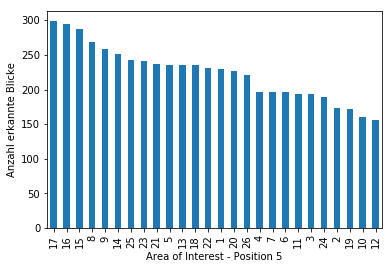

In [24]:
def count_aoi(frame_to_analyse, name):
    aoi_total = pd.DataFrame({'count' : frame_to_analyse.groupby('annotation_aoi')['client_id'].count()}).reset_index()

    aoi_total = aoi_total.sort_values(by=['count'], ascending=False)
    ax = aoi_total['count'].plot(kind='bar')
    ax.set_xticklabels(aoi_total[['annotation_aoi']].values.transpose()[0])
    
    display(aoi_total.head(10))
    
    print("Total - " + name + ": " + str(aoi_total['count'].sum()))

    count = aoi_total.loc[aoi_total['annotation_aoi'].isin([1,3,4,6,9,13,22])]['count'].sum()
    print("Oben (1,3,4,6,9,13,22): " + str(count) + " Avg: " + str(count/7))

    count = aoi_total.loc[aoi_total['annotation_aoi'].isin([14, 15, 16, 17, 7])]['count'].sum()
    print("Mitte (14, 15, 16, 17, 7): " + str(count) + " Avg: " + str(count/5))

    count = aoi_total.loc[aoi_total['annotation_aoi'].isin([2,5,8,10,11,18,19,20,21,23])]['count'].sum()
    print("Unten (2,5,8,10,11,18,19,20,21,23): " + str(count) + " Avg: " + str(count/10))

    count = aoi_total.loc[aoi_total['annotation_aoi'].isin([24,25,26])]['count'].sum()
    print("Kühlschrank (24,25,26): " + str(count) + " Avg: " + str(count/3))
    
    print("------------------------")

    ax.set_xlabel("Area of Interest - " + name)
    ax.set_ylabel("Anzahl erkannte Blicke")

#Total count
#base_frame = giant_data_frame[(giant_data_frame[['gaze_direction_0_x','gaze_direction_0_y','gaze_direction_0_z']] != 0).all(axis=1)]
#count_aoi(base_frame, "Total")

#Positon 1
pos_1_frame = base_frame.loc[base_frame['annotation_pos'] == 1]
count_aoi(pos_1_frame, "Position 1")

#Positon 2
pos_1_frame = base_frame.loc[base_frame['annotation_pos'] == 2]
count_aoi(pos_1_frame, "Position 2")

#Positon 3
pos_1_frame = base_frame.loc[base_frame['annotation_pos'] == 3]
count_aoi(pos_1_frame, "Position 3")

#Positon 4
pos_1_frame = base_frame.loc[base_frame['annotation_pos'] == 4]
count_aoi(pos_1_frame, "Position 4")

#Positon 5
pos_1_frame = base_frame.loc[base_frame['annotation_pos'] == 5]
count_aoi(pos_1_frame, "Position 5")


**Ergebnis:** WAS IST DAS Ergebnis.

## Verteilung der Hits  auf AOIs - pro Nutzer

**Ziel:** WAS IST DAS ZIEL.

Text(0.5, 1.0, 'Nutzer')

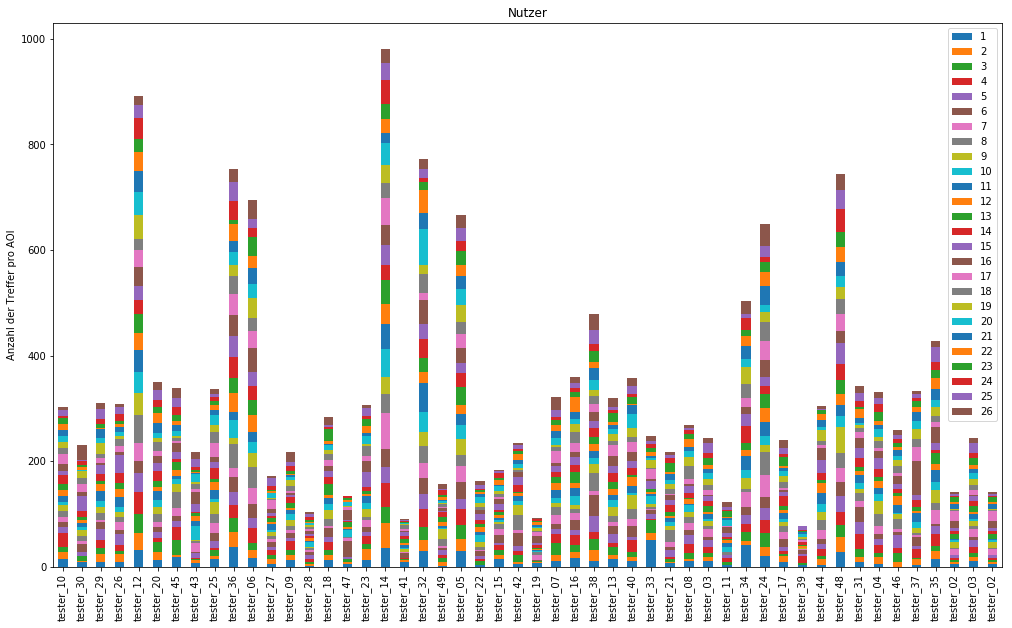

In [11]:
plt.rcParams["figure.figsize"] = (17, 10) # (w, h)

aoi_hits.transpose().plot(kind='bar', stacked=True)

plt.ylabel('Anzahl der Treffer pro AOI')
plt.title('Nutzer')

**Ergebnis:** WAS IST DAS Ergebnis.

<a id="cell4"></a>
# Frage 4: Verteilung der Hits auf die einzelnen Positionen

**Ziel:** WAS IST DAS ZIEL.

## Verteilung der Hits auf Positionen - gesamt

**Ziel:** Wie ist die Trefferrate pro Position. Welche Position ermöglicht viele Treffer und welche Position erhält am wenigsten Treffer.

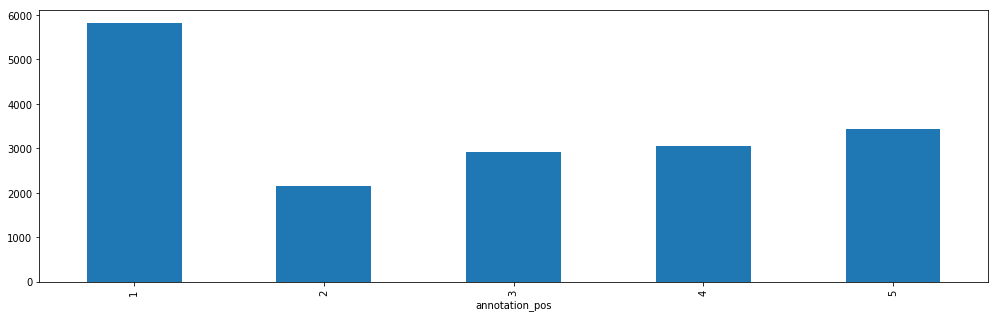

In [186]:
plt.rcParams["figure.figsize"] = (17, 5) # (w, h)
hits_total = giant_data_frame[(giant_data_frame[['gaze_direction_0_x','gaze_direction_0_y','gaze_direction_0_z']] != 0).all(axis=1)]
hits_total_count = hits_total.groupby('annotation_pos')['client_id'].count()

hits_total_1 = giant_data_frame[(giant_data_frame[['gaze_direction_0_x','gaze_direction_0_y','gaze_direction_0_z']] != 0).all(axis=1)]
hits_total_1 = hits_total_1[((hits_total_1[['client_id']] == 'cam_2') | (hits_total_1[['client_id']] == 'cam_3')).all(axis=1)]

hits_total_1 = hits_total_1[((hits_total_1[['annotation_pos']] == 1)).all(axis=1)]
hits_total_1_count = hits_total_1.groupby('client_id')['client_id'].count()

hits_total_1_count.plot('bar')
hits_total_count.plot('bar')


**Ergebnis:** WAS IST DAS Ergebnis.

## Verteilung der Hits auf Positionen - pro Nutzer

**Ziel:** WAS IST DAS ZIEL.

Text(0.5, 1.0, 'Nutzer')

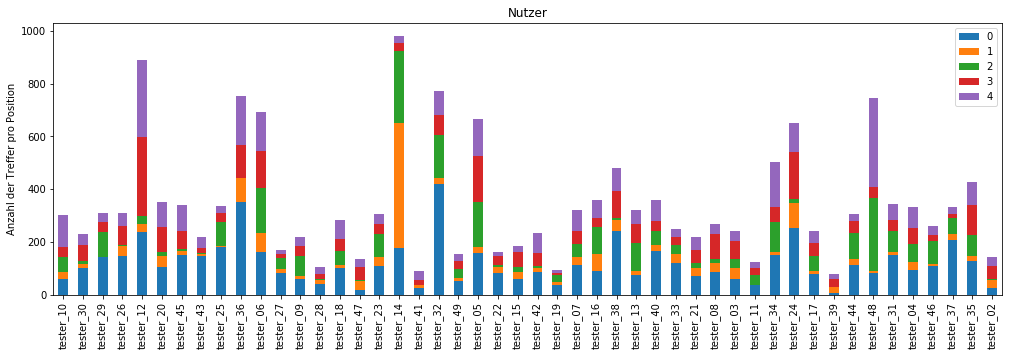

In [13]:
plt.rcParams["figure.figsize"] = (17, 5) # (w, h)

df=pd.DataFrame(position_hits).transpose()
df.plot(kind='bar', stacked=True)

plt.ylabel('Anzahl der Treffer pro Position')
plt.title('Nutzer')

**Ergebnis:** WAS IST DAS Ergebnis.

<a id="cell5"></a>
# Frage 5: Verteilung der Hits auf die AOIs pro Position

**Ziel:** WAS IST DAS ZIEL.

In [14]:
import numpy as np
import pandas as pd
import itertools
from operator import itemgetter

#ar is array of dataframes, choice1 is max value annotation_pos +1, choice2 is max value annotation_aoi +1
def pandasnumpy(ar,choice1,choice2):
    tester_names = list(  set(list(itertools.chain(*[list(_df.columns.values) for _df in ar]))).difference({'annotation_pos','annotation_aoi'}))                            
    res = pd.DataFrame()
    x = list(itertools.product(range(1,choice1), range(1,choice2)))
    res['crit'] = x
    res['annotation_pos'] =list(map(itemgetter(0), x))
    res['annotation_aoi'] =list(map(itemgetter(1), x))
    for _tester in tester_names:
        res[_tester] = np.full(res.shape[0],0)
    for _df in ar:
        _tester = [_val for _val in list(_df.columns.values) if _val != 'annotation_pos' and _val != 'annotation_aoi'][0]
        _df['crit'] = list(zip(_df['annotation_pos'], _df['annotation_aoi']))
        _res = pd.concat([res,_df])[['crit',_tester,'annotation_pos', 'annotation_aoi']]
        _res = _res.drop_duplicates(subset='crit', keep="last")
        _res = _res.sort_values(['annotation_pos', 'annotation_aoi'], ascending=[True, True]).reset_index()
        res[_tester] = _res[_tester]
    res['results_zip'] = list(zip(*[res[_tester] for _tester in tester_names]))
    zerotup = tuple(0 for i in range(0,len(tester_names)))
    res = res[res['results_zip'] != zerotup]
    rel_cols = tester_names + ['annotation_pos', 'annotation_aoi']
    res = res[rel_cols]
    return res

res = pandasnumpy(positions_by_aoi_hits,6,27)
print(res)

#plt.rcParams["figure.figsize"] = (17, 8) # (w, h)

#post_aoi_df = res.pivot(index=res['annotation_pos'], columns='annotation_aoi')
#post_aoi_df.plot.barh(stacked=True);

#plt.ylabel('Positionen')
#plt.title('AOI Verteilung')

/Users/markusguder/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



     tester_27  tester_23  tester_45  tester_44  tester_24  tester_36  \
0            3          6         10          0         11         20   
1            0          6          3          2          5         11   
2            3          6         21          0          9         15   
3            5          7         12          4          7         12   
4            2          0          8          3         13         14   
5            1          3          5          1          8         27   
6            2          7          9          9         31         11   
7            4          1          4          7         38         19   
8            1          4          3          4          4          4   
9            2          8          4          9          6         10   
10           8          8          4          5         16          6   
11           2          3          3         12          9         23   
12           4          3          9          4    

In [15]:
positions = [1,2,3,4,5]
aois = range(1, 26)

print(post_aoi_df)

harvest = np.nan_to_num(post_aoi_df.values)

fig, ax = plt.subplots()
im = ax.imshow(harvest)

# We want to show all ticks...
ax.set_xticks(np.arange(len(aois)))
ax.set_yticks(np.arange(len(positions)))

# ... and label them with the respective list entries

ax.set_xticklabels(aois)
ax.set_yticklabels(positions)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for num in [0,1,2,3,4]:
    for j in aois:
        text = ax.text(j, num, str(int(harvest[num][j])), ha="center", va="center", color="r")

ax.set_title("Hits der AOI pro Position")
# Add colorbar, make sure to specify tick locations to match desired ticklabels
#cbar = fig.colorbar(im, ticks=[-1, 0, 14])
#cbar.ax.set_yticklabels(['< -1', '0', '> 14']) 

plt.show()

NameError: name 'post_aoi_df' is not defined

**Ergebnis:** WAS IST DAS Ergebnis.

<a id="cell6"></a>
# Frage 6: Verteilung der Hits auf die Clients

**Ziel:** WAS IST DAS ZIEL.

Text(0.5, 1.0, 'Nutzer')

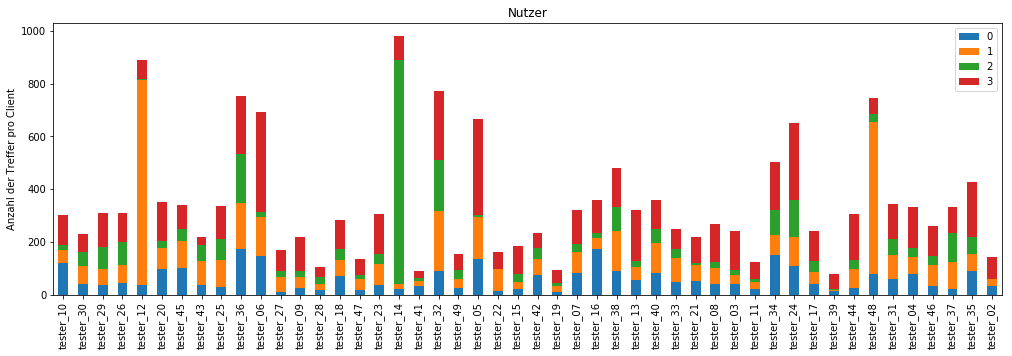

In [16]:
plt.rcParams["figure.figsize"] = (17, 5) # (w, h)

df=pd.DataFrame(client_data).transpose()
df.plot(kind='bar', stacked=True)

plt.ylabel('Anzahl der Treffer pro Client')
plt.title('Nutzer')

**Ergebnis:** WAS IST DAS Ergebnis.

[17.41539913 27.98019102 17.63353378 36.97087608]
client_id
cam_1    2954
cam_2    4746
cam_3    2991
cam_4    6271
Name: client_id, dtype: int64


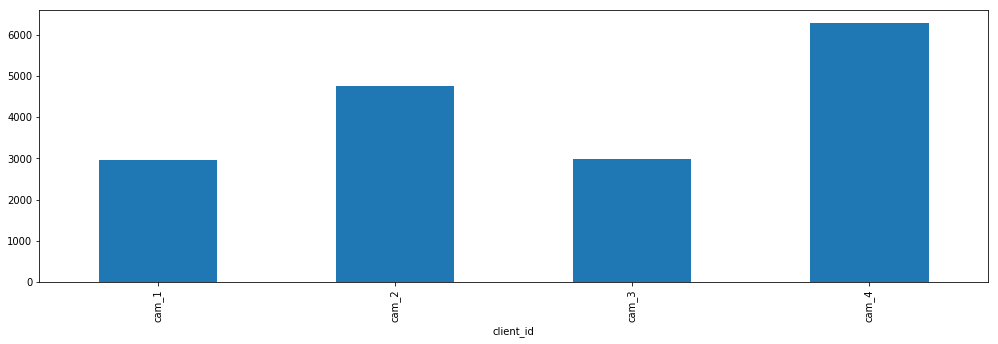

In [199]:
clients_total = giant_data_frame[(giant_data_frame[['gaze_direction_0_x','gaze_direction_0_y','gaze_direction_0_z']] != 0).all(axis=1)]
clients_total = clients_total.groupby('client_id')['client_id'].count()

print((clients_total.values/clients_total.values.sum() * 100))

clients_total.plot('bar')
print(clients_total)


# Frage 7: Personenbezogene Daten

In [ ]:
print()